Introduction
------
I started this bit of analysis with the hope that it would give me a better idea of the structure of a company's stock price i.e. what a typical price series looks like, the distribution of stock price and (most importantly) how correlated specific companies are to each other. The first idea I had in mind was to create a correlation web of all the companies in the S&P 500 and then based on that try ot determine whether I could predict stock changes using the stock price of one or a few companies. 

In [148]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.lda import LDA
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn import covariance, manifold, cluster
import math
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

In [3]:
stock = pd.read_excel("Stock_Data_Perf.xlsx")

In [4]:
avrg = stock.iloc[:, 1::8]

In [5]:
perc = pd.DataFrame([x for x in range(len(avrg)-1)])

In [6]:
for x in range(0, len(perc)-1):    
    perc = perc.join(avrg.iloc[:, x:x+1].pct_change(), how="inner")


In [7]:
del perc[0]

In [8]:
pct_change = perc

In [155]:
pct_change.fillna(value=0, inplace=True)

In [10]:
pct_change.head()

Avrg_MMM  Avrg_ABT  Avrg_ABBV  Avrg_ACN  Avrg_ATVI  Avrg_AYI  Avrg_ADBE  \
0  0.000000  0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
1 -0.014469 -0.002747  -0.012602 -0.017170  -0.008606 -0.019809  -0.006697   
2 -0.013130 -0.007288  -0.005420 -0.008478  -0.015822 -0.018667  -0.012943   
3  0.000526  0.002130  -0.051352  0.216648  -0.018302  0.010167   0.270513   
4  0.014978  0.015967   0.105428 -0.154528  -0.001487  0.025968  -0.201226   

   Avrg_AAP  Avrg_AES  Avrg_AET    ...     Avrg_XEL  Avrg_XRX  Avrg_XLNX  \
0  0.000000  0.000000  0.000000    ...     0.000000  0.000000   0.000000   
1 -0.015363 -0.017857 -0.013259    ...    -0.002328 -0.021696  -0.008900   
2 -0.008828 -0.022356  0.000282    ...     0.002769 -0.015154  -0.015643   
3  0.017692 -0.115218  0.279313    ...     0.054155 -0.220814   0.114056   
4  0.021904  0.133761 -0.187620    ...    -0.036960  0.316865  -0.094348   

    Avrg_XL  Avrg_XYL  Avrg_YHOO  Avrg_YUM  Avrg_ZBH  Avrg_ZION  Avrg_ZTS  
0  0.000000  0.000000   0.000000  0.000000       0.0   0.000000  0.000000  
1 -0.000871 -0.043141  -0.016815 -0.015173       0.0  -0.025278 -0.003745  
2  0.010684 -0.026531  -0.004858 -0.016488       0.0  -0.037570 -0.008387  
3  0.038580  0.145424  -0.217830  0.015364       0.0   0.101106  0.105633  
4 -0.021775 -0.117136   0.287400  0.023125       0.0  -0.088800 -0.062015  

[5 rows x 503 columns]

In [11]:
corr = pct_change.corr()

In [12]:
corr.head()

Avrg_MMM  Avrg_ABT  Avrg_ABBV  Avrg_ACN  Avrg_ATVI  Avrg_AYI  \
Avrg_MMM   1.000000  0.437284   0.208254  0.189038   0.236210  0.370529   
Avrg_ABT   0.437284  1.000000   0.392263  0.159294   0.267160  0.351291   
Avrg_ABBV  0.208254  0.392263   1.000000 -0.275109  -0.126807  0.033149   
Avrg_ACN   0.189038  0.159294  -0.275109  1.000000   0.246532  0.251756   
Avrg_ATVI  0.236210  0.267160  -0.126807  0.246532   1.000000  0.445938   

           Avrg_ADBE  Avrg_AAP  Avrg_AES  Avrg_AET    ...     Avrg_XEL  \
Avrg_MMM    0.141699  0.305690  0.305993  0.108235    ...     0.180049   
Avrg_ABT    0.173972  0.333119  0.261088  0.161198    ...     0.123491   
Avrg_ABBV  -0.276401  0.296196  0.483440 -0.133275    ...    -0.381264   
Avrg_ACN    0.920508  0.081262 -0.512995  0.860700    ...     0.388160   
Avrg_ATVI   0.297679  0.062880 -0.127662  0.081908    ...     0.487425   

           Avrg_XRX  Avrg_XLNX   Avrg_XL  Avrg_XYL  Avrg_YHOO  Avrg_YUM  \
Avrg_MMM   0.178099   0.223434  0.350603  0.235734   0.196207  0.330346   
Avrg_ABT   0.130262   0.226348  0.371378  0.164221   0.217989  0.315955   
Avrg_ABBV  0.310486  -0.109016  0.258609 -0.239137   0.500390  0.161767   
Avrg_ACN  -0.654793   0.730768  0.267067  0.827711  -0.624903  0.136985   
Avrg_ATVI  0.066553   0.320222  0.100597  0.335887   0.127891  0.216231   

           Avrg_ZBH  Avrg_ZION  Avrg_ZTS  
Avrg_MMM   0.255558   0.267195  0.193068  
Avrg_ABT   0.443931   0.230322  0.303349  
Avrg_ABBV  0.302018   0.028904  0.221910  
Avrg_ACN   0.149683   0.691461  0.594785  
Avrg_ATVI  0.259779   0.033089  0.167839  

[5 rows x 503 columns]

In [13]:
data = corr.values

In [14]:
pca = PCA(n_components=len(corr)-1)

In [15]:
data_r = pca.fit(data).transform(data)

In [16]:
labels = [x for x in pct_change.head(0)]

Initial Visualisation
--

Correlation Web
----------------------------------------------------------------------------------------------------------------------
The PCA graph below shows the correlation web of the S&P500. The spacing in between the companies represents the degree of correlation between the two companies. An example is shown below- this demonstrates that Amazon and Nvidia are indeed very tightly correlated, and they can be seen to be placed very close to each other in the top left hand corner. 
This is the web that I will try to come back to, to predict movement of stocks based on the change in other stocks.

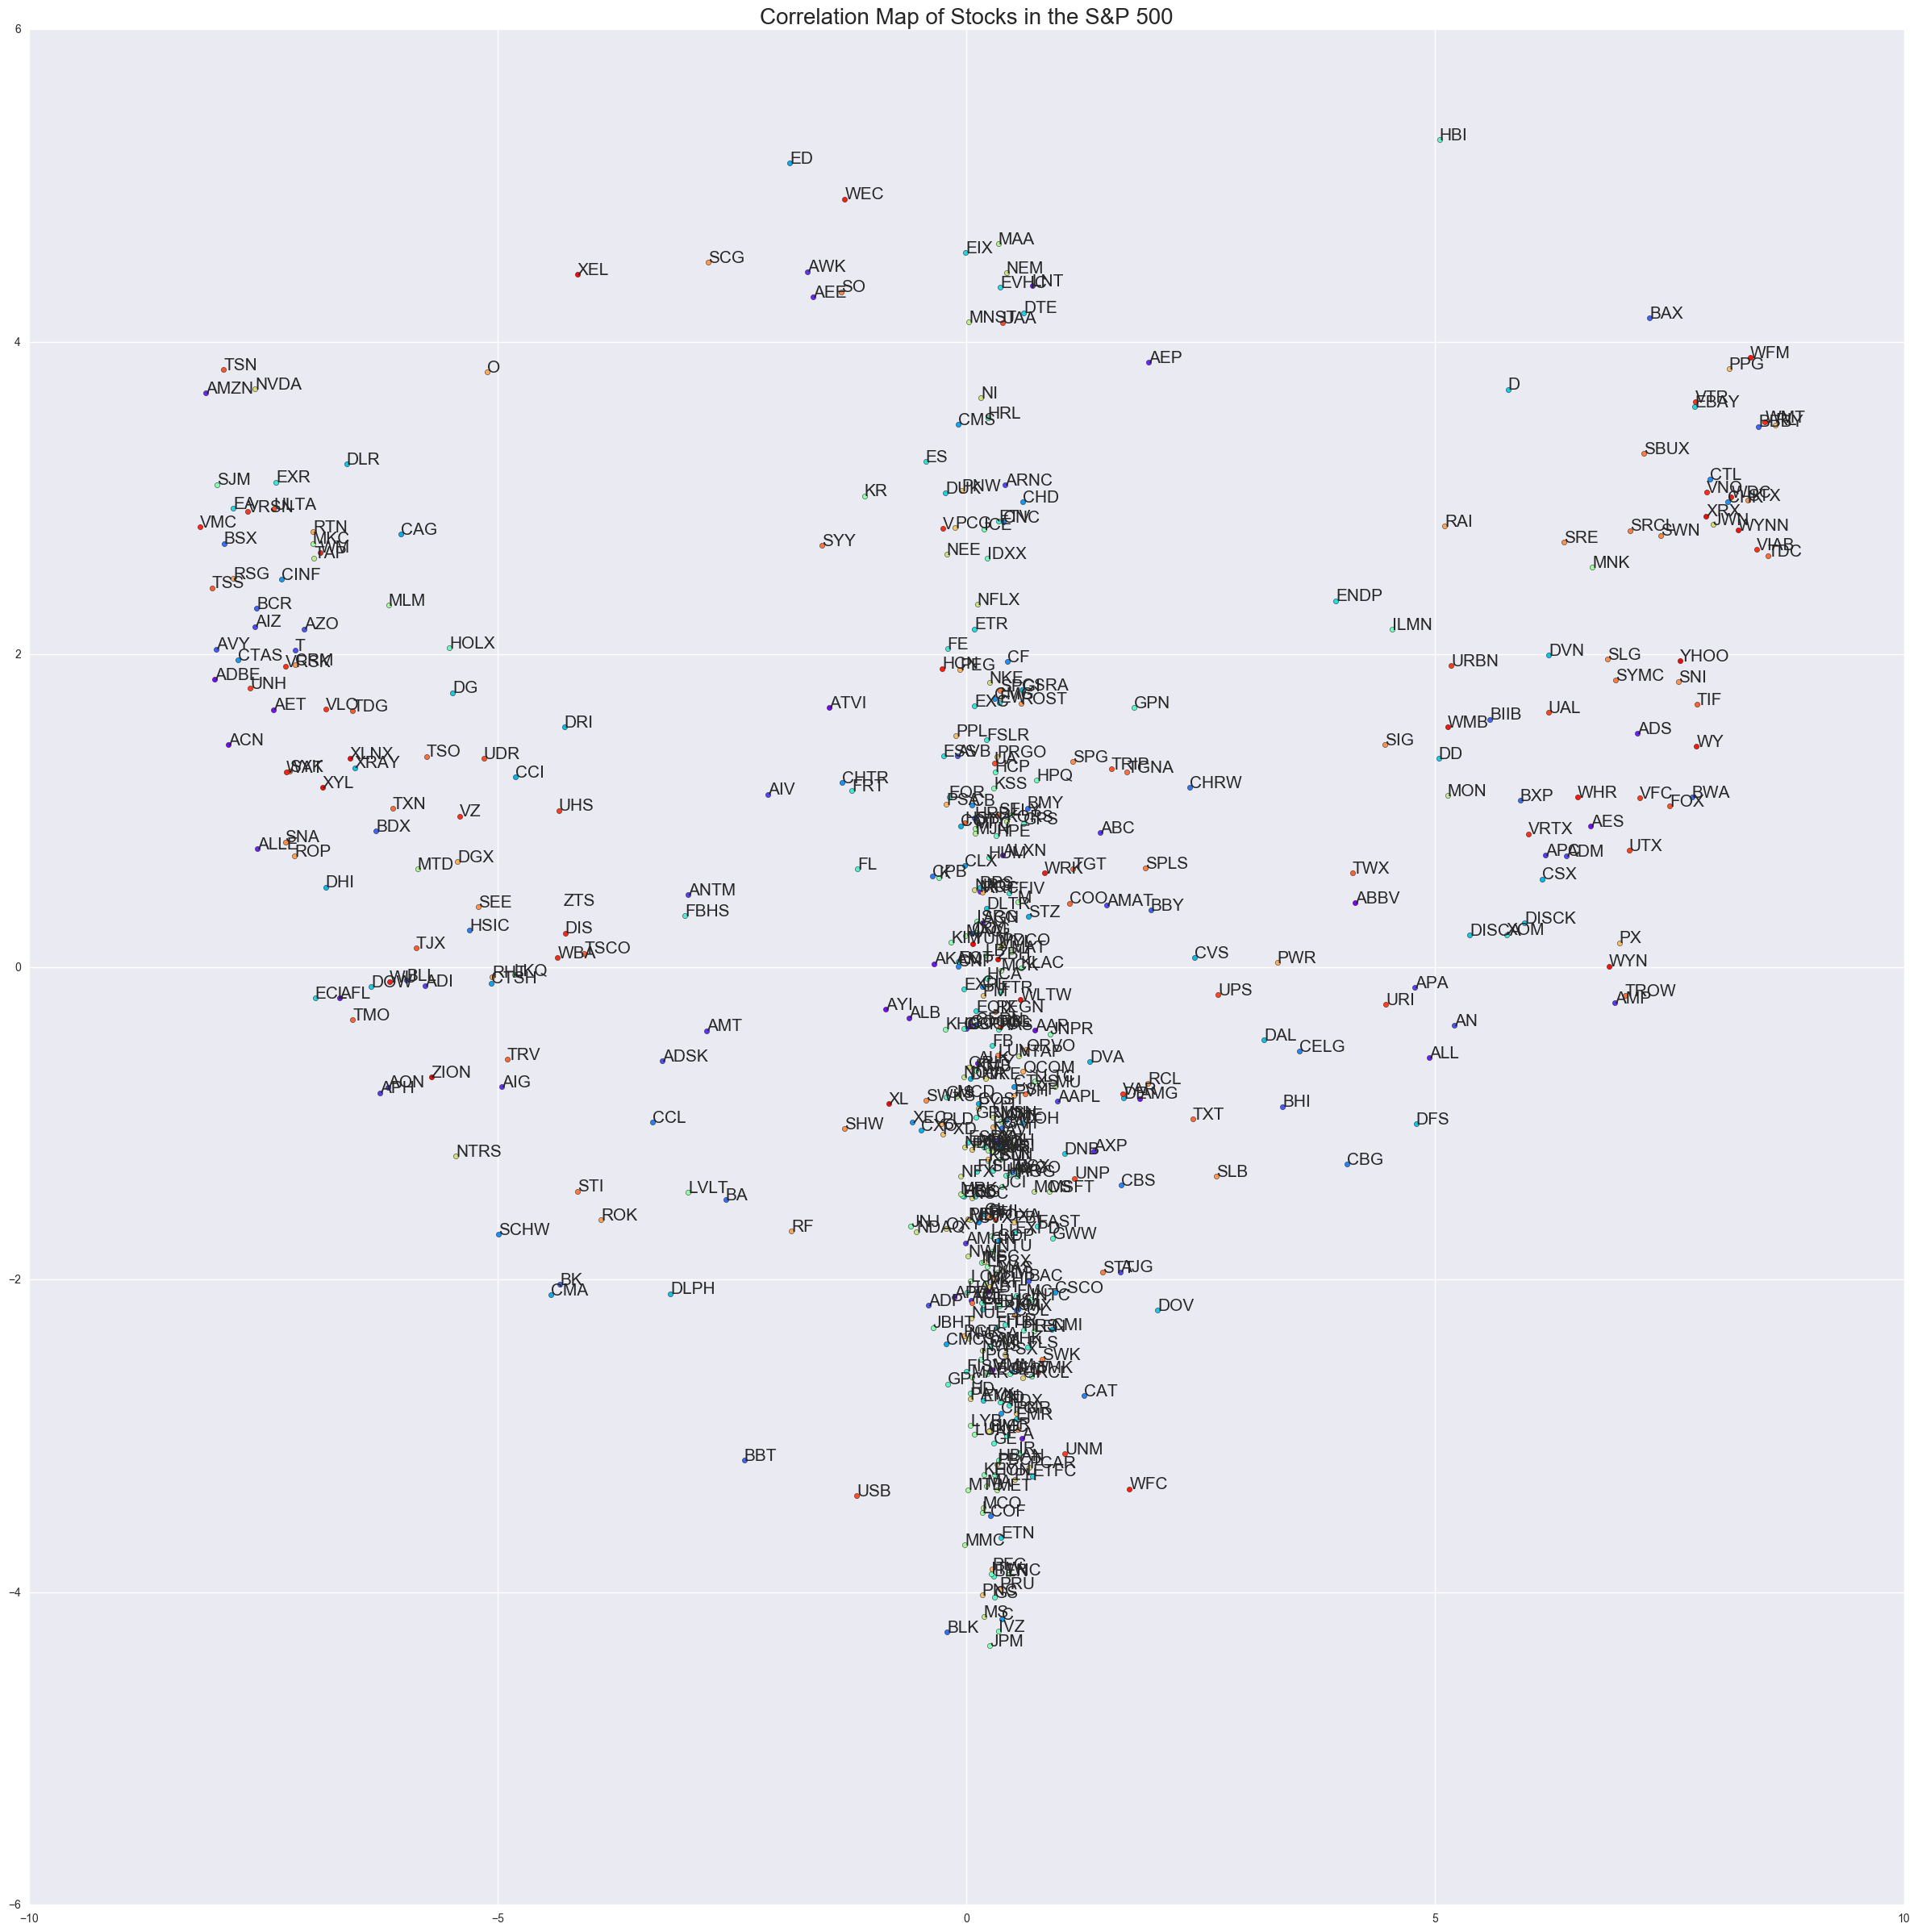

In [120]:
fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(labels)-1))
for c, i, target_name in zip(colors, [i for i in range(0, len(labels)-1)], labels):
    plt.scatter(data_r[i, 0], data_r[i, 1], c=c, alpha = 1)
    plt.legend()

for i, txt in enumerate(labels):
    plt.annotate(txt[5:], (data_r[i, 0], data_r[i, 1]), fontsize=15)
    
plt.title("Correlation Map of Stocks in the S&P 500", fontsize=20)

plt.show()

In [18]:
np.corrcoef(np.array(stock['Avrg_AMZN']), np.array(stock['Avrg_NVDA']))

array([[ 1.        ,  0.80387565],
       [ 0.80387565,  1.        ]])

Stock Sensitivity
----------------------------------------------------------------------------------------------------------------------
I am now going to highlight the stocks that are sensitive to the widest range of stocks in the S&P. I am doing this because this will be my "key stocks" i.e the stocks that I will pay most attention to, because they are more closely linked to a wide range of other stocks. It also helps to highlight the stocks that only have a few tightly correlated companies, which narrows down the field of companies that need to be analysed.

In [19]:
a = np.array([x for x in range(0, 10, 2)])
b = np.array([ y for y in range(0, 10, 2)])

In [20]:
def stock_sensitivity(comp):    
    x = [x for x in range(0, len(corr[comp])-1)]
    y = sorted([i for i in corr[comp] if i != 1])

    plt.scatter(np.array(x), np.array(y))
    m, b = np.polyfit(x, y, 1)

    x_ = [m*c + b for c in x]

    plt.plot(np.array(x), np.array(x_), '-', c='y')
    
    return m

0.00073509212143833748

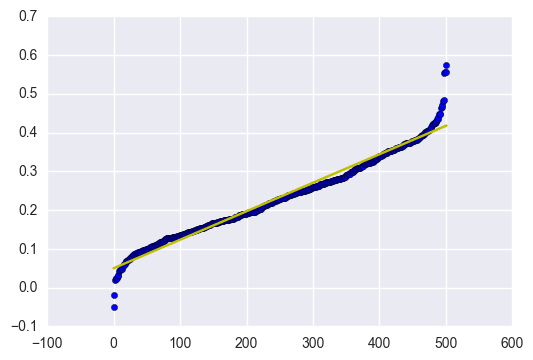

In [21]:
stock_sensitivity("Avrg_FB")

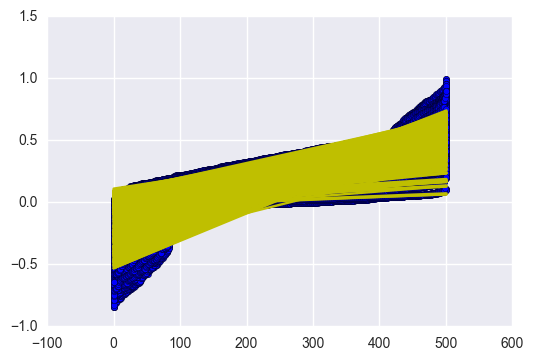

In [22]:
gradients = [stock_sensitivity(h) for h in corr.head(0)]

In [23]:
stock_sens_dict = {}
for b in range(len(gradients)):
    stock_sens_dict[[h for h in corr.head(0)][b]] = gradients[b]

In [24]:
combo = sorted(stock_sens_dict.items(), key=lambda x: x[1])

In [25]:
print 'Company \t Gradient of Correlation Scatter Graph'
print "-"*50
for n in range(1, 10):
    print '{0} \t\t\t {1}'.format(combo[len(combo)-n][0][5:], str(combo[len(combo)-n][1])[:9])
print "-"*50
for n in range(1, 10):
    print '{0} \t\t\t {1}'.format(combo[n-1][0][5:], str(combo[n-1][1])[:9])

Company 	 Gradient of Correlation Scatter Graph
--------------------------------------------------
VMC 			 0.0023156
TDC 			 0.0023123
SJM 			 0.0023058
TSN 			 0.0022993
RSG 			 0.0022974
VIAB 			 0.0022923
ADBE 			 0.0022909
RL 			 0.0022899
AMZN 			 0.0022899
--------------------------------------------------
EVHC 			 0.0001886
UAA 			 0.0002083
MAA 			 0.0002180
NI 			 0.0002658
ARNC 			 0.0002957
IDXX 			 0.0003180
NFLX 			 0.0003291
CHD 			 0.0003396
ICE 			 0.0003533


Stock Sensivity Reflection
----------------------------------------------------------------------------------------------------------------------
From the above printed table it's obvious to see that VMC is the most sensitive to the highest number of companies, while ICE is least sensitive. 
Using this list I would suggest keeping a close eye on these stocks for movement as they will indicate movement in either a large or small amount of stocks. 

More Visual Representation of the Correlation between One Company and the Rest of the S&P
----------------------------------------------------------------------------------------------------------------------
My initial idea was try and visualise a correlation hill for each company, with more correlated companies higher up the hill and less correlated companies further down the hill. I would try and use this "hill" to estimate the magnitude of movement done by other stocks when the "peak" stock is affected.

In [26]:
py.sign_in('am.short7', 'E0X28xzbcbrchyKwIOpa')

In [134]:
def comp_corr_graph(comp):
    a = pd.DataFrame(corr['{}'.format(comp)])

    x_coord = []
    y_coord = []

    for l in a.values:
        l_ = 1 - float(math.fabs(l))
        if l_ != 0:
            x = np.random.randint(-l_*10000, l_*10000)/float(10000)
            y = (l_*l_ - x*x)**(1/2.0)
        
            x_coord.append(x)
            y_coord.append(y)
        
        else:
            x_coord.append(float(0))
            y_coord.append(float(0))
        
    a['x_values'], a['y_values'] = x_coord, y_coord

    def circle(r, color):
        return plt.Circle((0, 0), r, color='{}'.format(color), fill=False, lw=7, alpha=0.4, label="Corr: {}".format(r))

    plt.figure(figsize=(30, 30))
    scatter = plt.scatter(a['x_values'], a['y_values'])

    circle1 = circle(0.1, 'r')
    circle2 = circle(0.2, 'g')
    circle3 = circle(0.3, 'b')
    circle4 = circle(0.4, 'r')
    circle5 = circle(0.6, 'g')
    circle6 = circle(0.8, 'y')
    circle7 = circle(1, 'r')

    fig = plt.gcf()
    ax = fig.gca()

    ax.add_artist(circle1)
    ax.add_artist(circle2)
    ax.add_artist(circle3)
    ax.add_artist(circle4)
    ax.add_artist(circle5)
    ax.add_artist(circle6)
    ax.add_artist(circle7)
    ax.add_artist(scatter)
    
    ax.set(title="Correlation map for the Company at (0,0)")
    
#     ax.legend(loc="upper right")
    
    comp_names = [c for c in avrg.head(0)]

    for i, txt in enumerate(comp_names):
        ax.annotate(txt[5:], (x_coord[i], y_coord[i]), fontsize=15)
        
    data = [
        go.Contour(
            z = [i for i in a['{}'.format(comp)].values],
            x = [z for z in a['x_values'].values],
            y = [w for w in a['y_values'].values],
            contours=dict(
                start=0, 
                end=1,
                size=0.1,
                
            )
        
    )]

    return py.iplot(data)

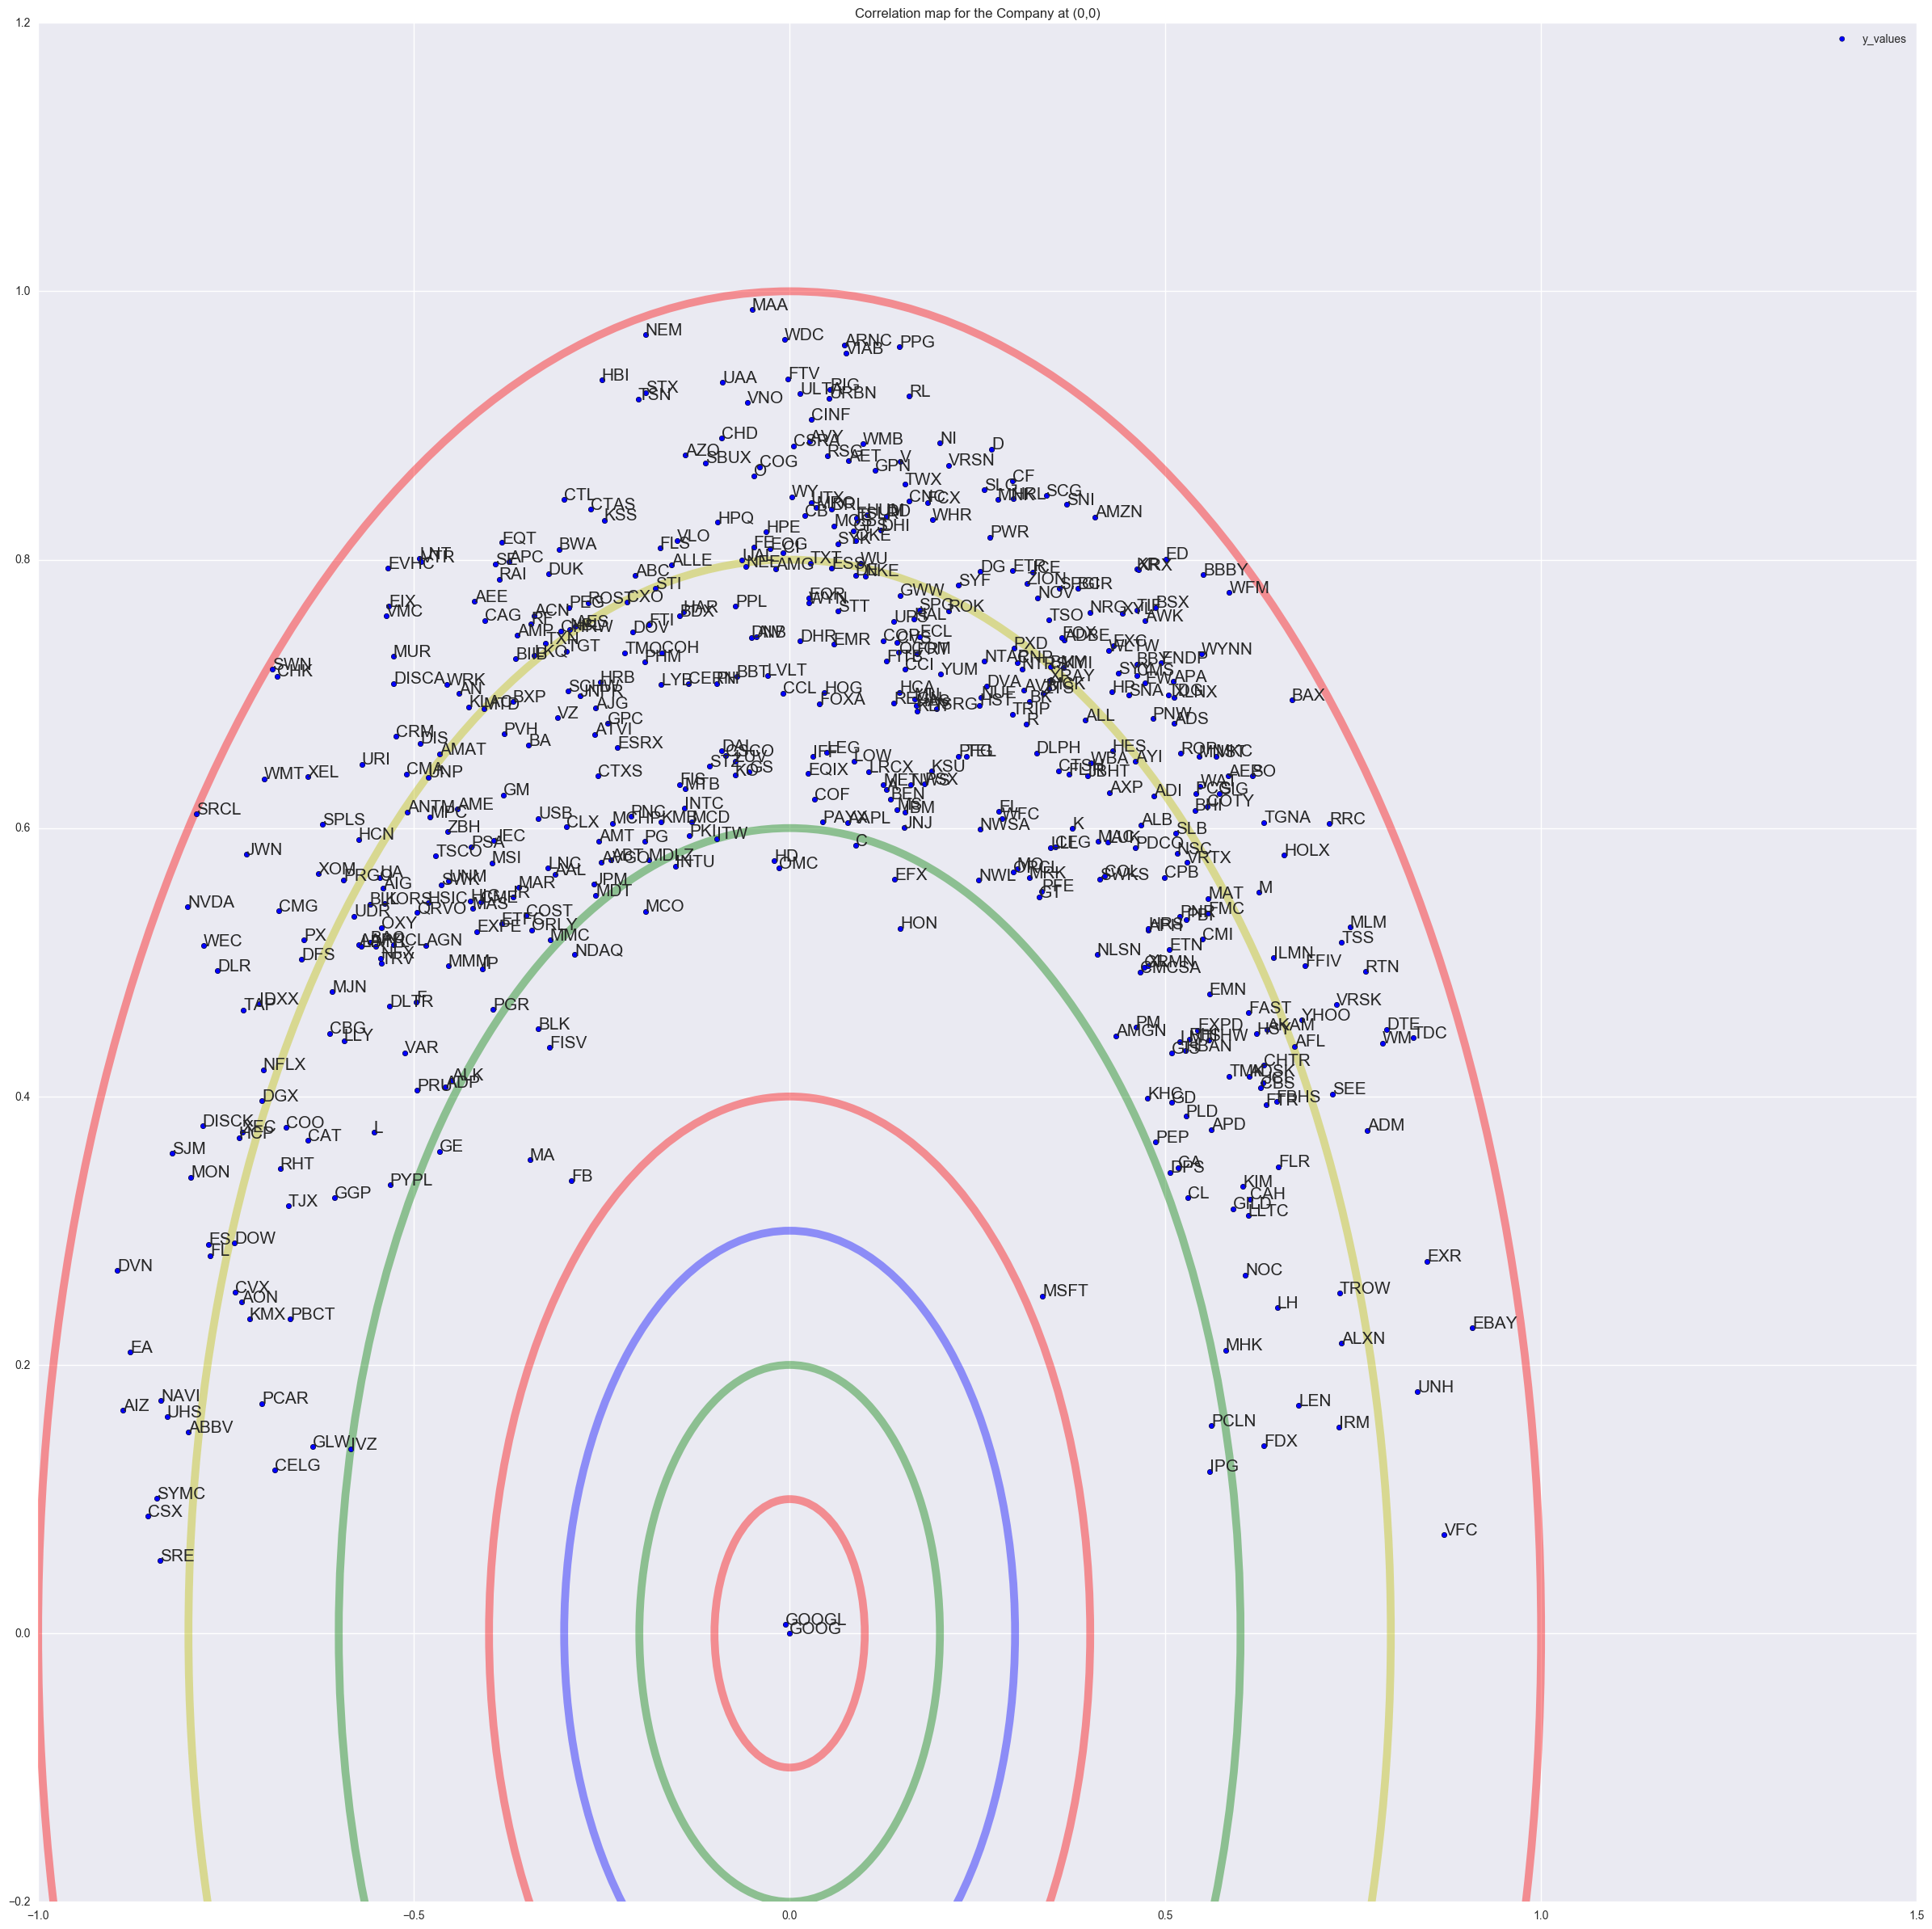

In [133]:
comp_corr_graph("Avrg_GOOG")

Quick Pairplot and Boxplot
---------
I randomly selected companies and did a pairplot to see if there was any broad distribution that was instantly obvious from the plots. 
It turns out that there wasn't much to show. Occasionally it showed 2 of the random companies were highly correlated to each other, but apart from that the scatter plots weren't very telling. 
The histograms were somewhat useful in a few cases. They showed skewed or poly-modal distributions. This kind of information could be useful in purely guessing the likelihood of the price, but in practice it probably won't help determine the exact direction of the stock movement.
I also produced some boxplots, again for a random selection of companies, just to get an idea of the distribution of stock prices. 
This analysis is very superficial and is to make me familiar with it, rather than resulting in anything conclusive. 

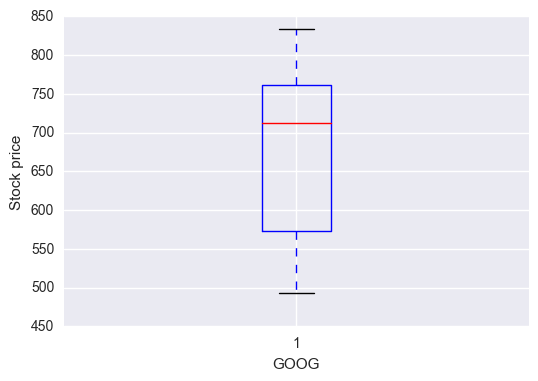

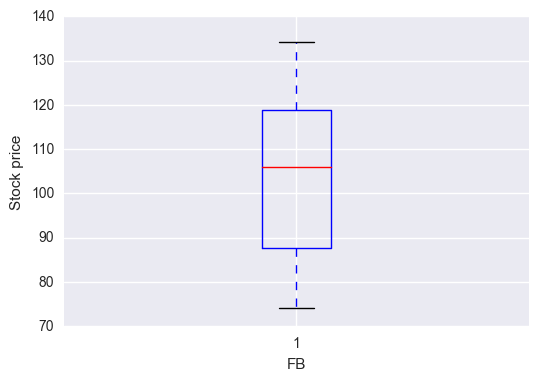

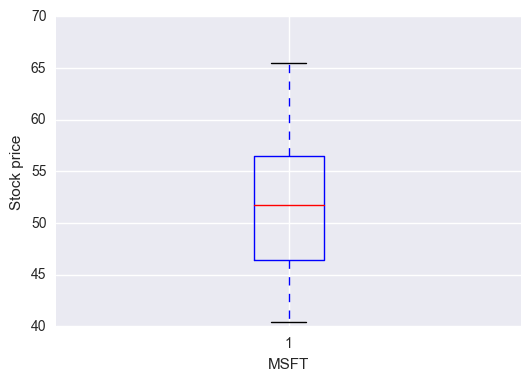

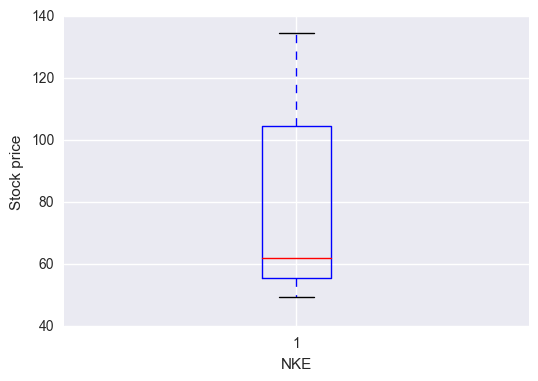

In [135]:
boxplots_ = ["Avrg_GOOG", "Avrg_FB", "Avrg_MSFT", "Avrg_NKE"]
for compan in boxplots_:
    plt.boxplot(avrg[compan])
    plt.xlabel("{}".format(compan[5:]))
    plt.ylabel("Stock price")
    plt.show()

In [29]:
demo = avrg.iloc[:, 1:100:10]

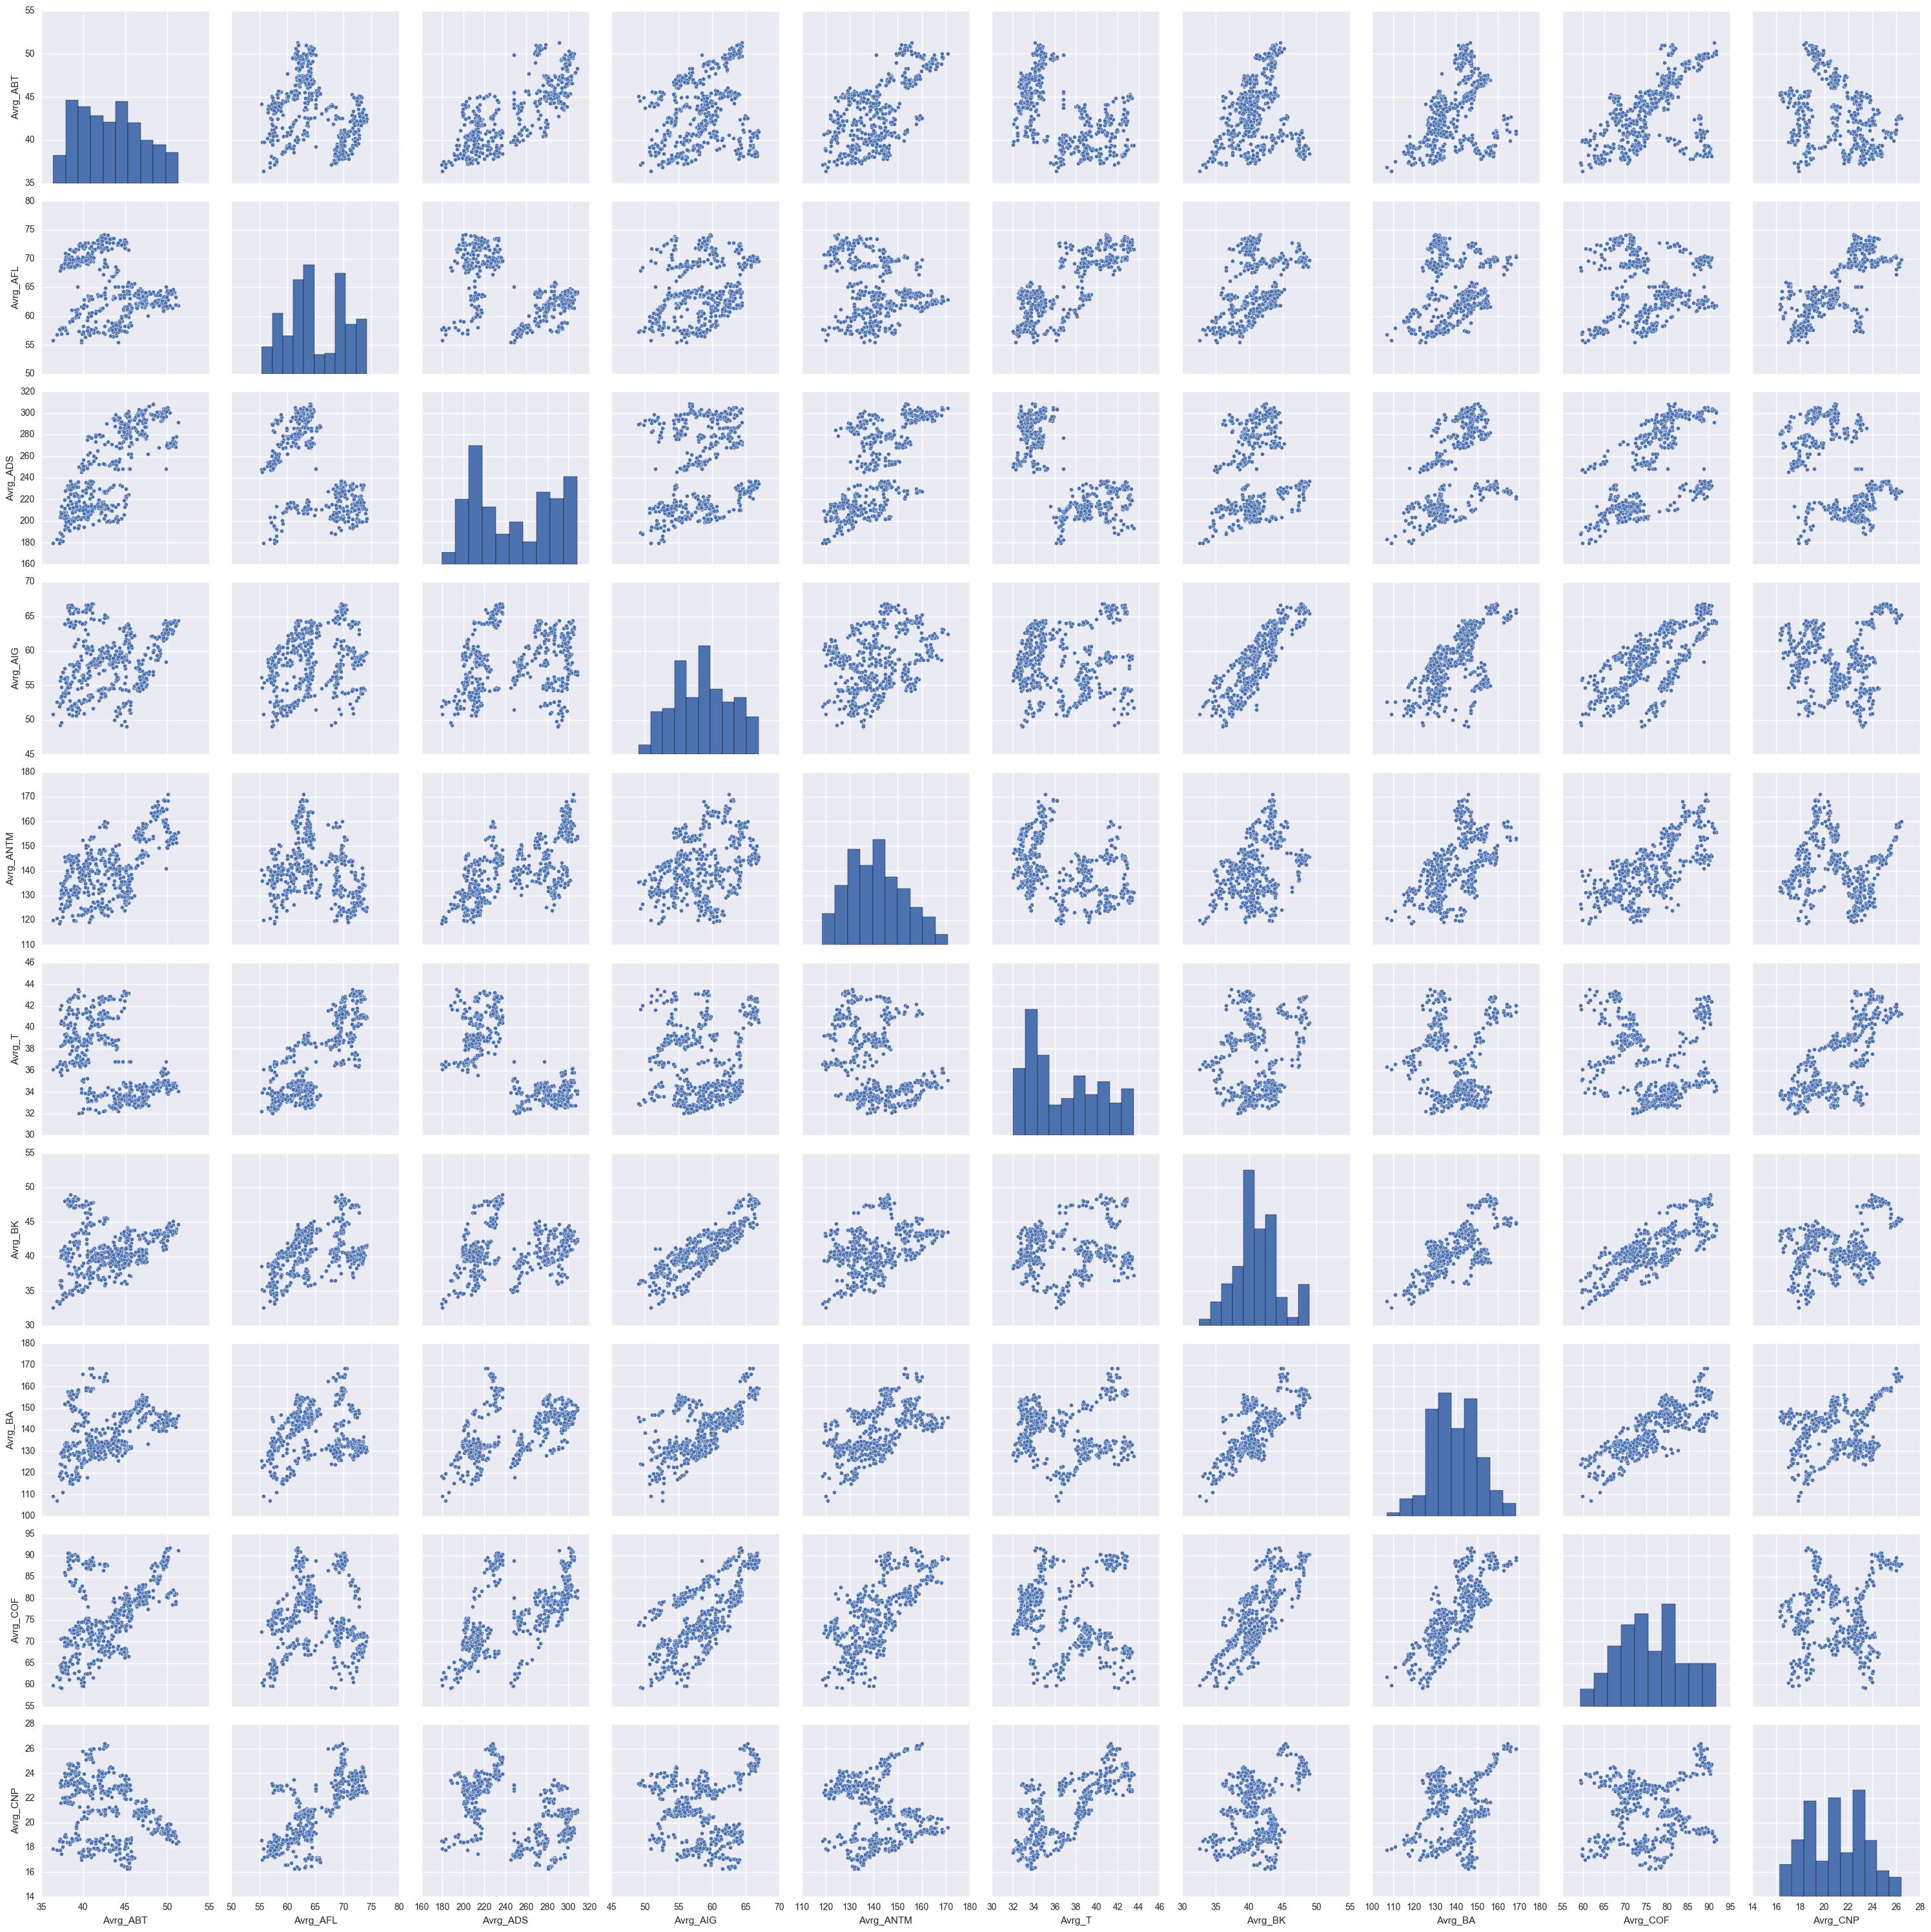

In [30]:
sns.pairplot(demo, size=3)

Basic Machine Learning
--
I will now focus on one company and try and find the best companies to predict it's stock price. I have chosen Facebook as my focus company, purely because of it's size and success over the last few years. Also, because it's super well known and everyone is fairly interested in events that affect its success.
I created a couple of definitions from the onset that both created dataframes that I would use as x values for the anlaysis, but the dataframes either contained the most correlated companies (first def function) or just a randomly inputted selection of companies (the second def function). The reason for this is because I wanted to see if there was significant difference between regressions done on companies that were highlighted to be more correlated as oppose to my own selection of companies, that I will output later on in the analysis. 

In [31]:
# Creates a dataframe that contains only the 7 companies most correlated to your chosen company
def comps_most_correlated(comp):
    corr_comps = corr.sort_values(by=['{}'.format(comp)], ascending=False).T
    threshold_comps = [str(a) for a in corr_comps.head(0) if a != '{}'.format(comp)]
    return pd.DataFrame(avrg, columns=[threshold_comps[:7]])

In [92]:
# Allows you to create a unique dataframe of companies based on your whims and fancies
def random_collection_of_companies(list_of_companies):
    return pd.DataFrame(avrg, columns=[list_of_companies])

In [32]:
parameters = {"max_depth":[3, 7, 13, 20, 30],
             "max_features":[None, "auto"],
             "min_samples_leaf":[2, 3, 5, 7, 9],
             "min_samples_split":[2, 5, 10],
             "criterion":['mse']}
ridge_alphas = np.logspace(0, 8, 200)

In [144]:
# Run a regression type by inputting your target company and the dataframe made up of companies that will be your x values
def regression_type(comp, x_values, model, parameters, ridge_alphas):
    corr_comps = corr.sort_values(by=['{}'.format(comp)], ascending=False).T
    companies = [str(a) for a in corr_comps.head(0) if a != '{}'.format(comp)]
    correlated_comps = comps_most_correlated('{}'.format(comp))
    
    lr = LinearRegression()
    dec_tree = DecisionTreeRegressor()
    

    y = avrg['{}'.format(comp)].values
    x = x_values.values
    
    ss = StandardScaler()
    Xn = ss.fit_transform(x)
    
    xtrain, xtest, ytrain, ytest = train_test_split(Xn, y, test_size=0.3, random_state=10)
    
    if model == "OLS":
        lr.fit(X=xtrain, y=ytrain)
        ytrain_pred, ytest_pred = lr.predict(xtrain), lr.predict(xtest)
        
        print "Using OLS I got the following results:\n"
        
        print "The coefficients are:"
        for i in range(len(lr.coef_)):
            print "{}:".format([h for h in x_values.head(0)][i][5:])
            print "\t{}".format(lr.coef_[i])
    
        print "The R squared score of the tested data is: {0:.2f}".format(r2_score(ytest, ytest_pred))
        print "The score for the trained data is: {0:.2f}".format(r2_score(ytrain, ytrain_pred))    
    
        print "The MSE value in the tested data is: {0:.2f}".format(mean_squared_error(ytest, ytest_pred))
        print "The value for trained data is: {0:.2f}".format(mean_squared_error(ytrain, ytrain_pred))
        
        fig = plt.figure(figsize=(10, 10))
        
        scatter_test = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest), c='r', marker='o', label="Actual {} Values".format(comp[5:]))
        scatter_pred = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest_pred), c='b', marker='*', label ="Predicted Values for {}".format(comp[5:]))
        
        fig = plt.gcf()
        ax = fig.gca()
        
        ax.add_artist(scatter_test)
        ax.add_artist(scatter_pred)
        
        ax.legend(loc="upper right")
        ax.set(title="Plotting Predicted vs Original Values of {}".format(comp[5:]))
        
        plt.show()
        
    elif model == "decision tree":
        dec_tree_gs = GridSearchCV(dec_tree, parameters, n_jobs=-1, verbose=1)
        dec_tree_gs.fit(xtrain, ytrain)
       
        best_model = dec_tree_gs.best_estimator_
        ytrain_pred = best_model.predict(xtrain)
        ytest_pred = best_model.predict(xtest)
        
        print "Using Decision Tree analysis I got the following results and statistics:\n"
    
        feature_importance = pd.DataFrame({'feature':x_values.columns, 'importance':best_model.feature_importances_})
        print feature_importance
        print "The R squared score of the tested data is: {0:.2f}".format(r2_score(ytest, ytest_pred))
        print "The score for the trained data is: {0:.2f}".format(r2_score(ytrain, ytrain_pred))    
    
        print "The MSE value in the tested data is: {0:.2f}".format(mean_squared_error(ytest, ytest_pred))
        print "The value for trained data is: {0:.2f}".format(mean_squared_error(ytrain, ytrain_pred))
            
        fig = plt.figure(figsize=(10, 10))
        
        scatter_test = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest), c='r', marker='o', label="Actual {} Values".format(comp[5:]))
        scatter_pred = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest_pred), c='b', marker='*', label ="Predicted Values for {}".format(comp[5:]))
        
        fig = plt.gcf()
        ax = fig.gca()
        
        ax.add_artist(scatter_test)
        ax.add_artist(scatter_pred)
        
        ax.legend(loc="upper right")
        ax.set(title="Plotting Predicted vs Original Values of {}".format(comp[5:]))
        
        plt.show()
        
    elif model == "Ridge":
        optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
        optimal_ridge.fit(xtrain, ytrain)
        ridge = Ridge(alpha=optimal_ridge.alpha_)
        ridge.fit(xtrain, ytrain)
        ytrain_pred = ridge.predict(xtrain)
        ytest_pred = ridge.predict(xtest)
        
        print "Using the Ridge model, I got the following results and statistics:\n"
        
        print "The coefficients are:"
        for i in range(len(ridge.coef_)):
            print "{}:".format([h for h in x_values.head(0)][i][5:])
            print "\t{}".format(ridge.coef_[i])
        
        print "The R squared score of the tested data is: {0:.2f}".format(r2_score(ytest, ytest_pred))
        print "The score for the trained data is: {0:.2f}".format(r2_score(ytrain, ytrain_pred))    
    
        print "The MSE value in the tested data is: {0:.2f}".format(mean_squared_error(ytest, ytest_pred))
        print "The value for trained data is: {0:.2f}".format(mean_squared_error(ytrain, ytrain_pred))
        
        fig = plt.figure(figsize=(10, 10))
        
        scatter_test = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest), c='r', marker='o', label="Actual {} Values".format(comp[5:]))
        scatter_pred = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest_pred), c='b', marker='*', label ="Predicted Values for {}".format(comp[5:]))
        
        fig = plt.gcf()
        ax = fig.gca()
        
        ax.add_artist(scatter_test)
        ax.add_artist(scatter_pred)
        
        ax.legend(loc="upper right")
        ax.set(title="Plotting Predicted vs Original Values of {}".format(comp[5:]))
        
        plt.show()
        
    elif model == "Lasso":
        optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
        optimal_lasso.fit(xtrain, ytrain)
        lasso = Lasso(alpha=optimal_lasso.alpha_)
        lasso.fit(xtrain, ytrain)
        ytrain_pred = lasso.predict(xtrain)
        ytest_pred = lasso.predict(xtest)
        
        print "Using the Lasso model, I got the following results and statistics:\n"
        
        print "The coefficients are:"
        for i in range(len(lasso.coef_)):
            print "{}:".format([h for h in x_values.head(0)][i][5:])
            print "\t{}".format(lasso.coef_[i])
    
        print "The R squared score of the tested data is: {0:.2f}".format(r2_score(ytest, ytest_pred))
        print "The score for the trained data is: {0:.2f}".format(r2_score(ytrain, ytrain_pred))    
    
        print "The MSE value in the tested data is: {0:.2f}".format(mean_squared_error(ytest, ytest_pred))
        print "The value for trained data is: {0:.2f}".format(mean_squared_error(ytrain, ytrain_pred))
        
        fig = plt.figure(figsize=(10, 10))
        
        scatter_test = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest), c='r', marker='o', label="Actual {} Values".format(comp[5:]))
        scatter_pred = plt.scatter([i for i in range(0, len(ytest))], sorted(ytest_pred), c='b', marker='*', label ="Predicted Values for {}".format(comp[5:]))
        
        fig = plt.gcf()
        ax = fig.gca()
        
        ax.add_artist(scatter_test)
        ax.add_artist(scatter_pred)
        
        ax.legend(loc="upper right")
        ax.set(title="Plotting Predicted vs Original Values of {}".format(comp[5:]))
        
        plt.show()
    
    else:
        print "The models need to be inputted as: OLS, decision tree, Lasso or Ridge. The x_values need to be inputted as a dataframe."

In [34]:
comps_most_correlated("Avrg_FB").head()

Avrg_MA  Avrg_GOOGL  Avrg_GOOG  Avrg_PYPL    Avrg_HD  Avrg_FISV   Avrg_CL
0  86.161075  531.457500  527.29750   37.63758  104.22870    71.1150  69.04250
1  84.239975  523.087475  518.63000   37.63758  101.90250    70.1075  68.83660
2  83.082475  513.475000  508.54625   37.63758  101.35750    69.9100  68.26000
3  83.917500  507.810000  503.74850   37.63758  103.29125    70.4300  68.16375
4  85.342500  502.735000  498.78750   37.63758  106.02500    71.9600  69.05500

Using OLS I got the following results:

The coefficients are:
MA:
	0.324454847716
GOOGL:
	12.2160288261
GOOG:
	-0.874460133945
PYPL:
	1.64184407496
HD:
	-3.24793793262
FISV:
	7.59086697404
CL:
	2.54194319367
The R squared score of the tested data is: 0.96
The score for the trained data is: 0.96
The MSE value in the tested data is: 12.64
The value for trained data is: 11.87


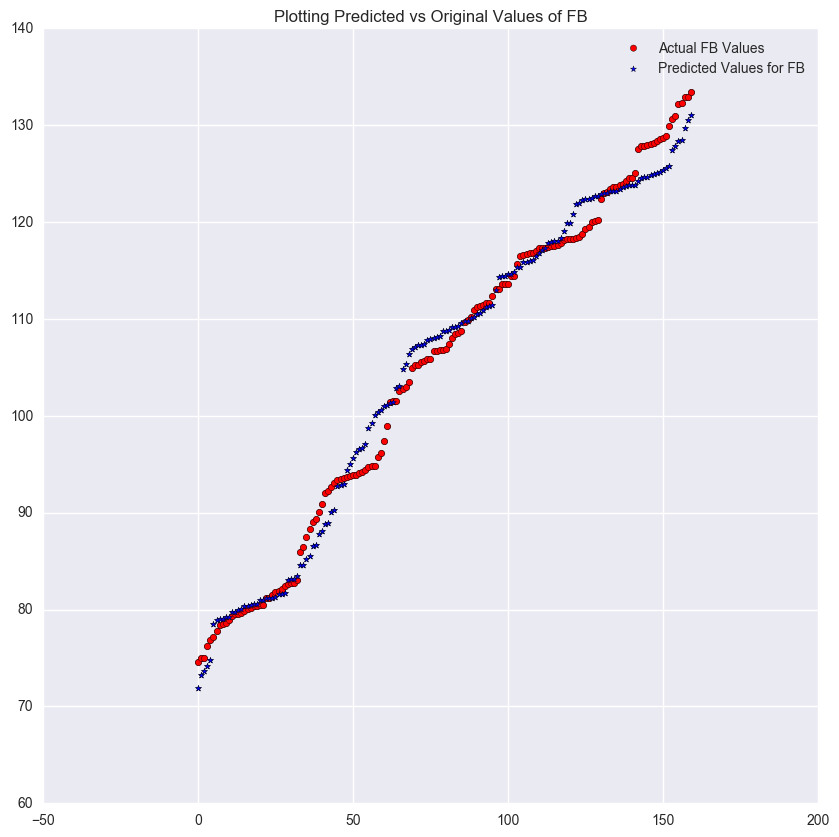

In [115]:
regression_type("Avrg_FB", comps_most_correlated("Avrg_FB"), "OLS", parameters, ridge_alphas)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.5s finished


Using Decision Tree analysis I got the following results and statistics:

      feature  importance
0     Avrg_MA    0.006163
1  Avrg_GOOGL    0.048101
2   Avrg_GOOG    0.002741
3   Avrg_PYPL    0.003073
4     Avrg_HD    0.004006
5   Avrg_FISV    0.927574
6     Avrg_CL    0.008341
The R squared score of the tested data is: 0.97
The score for the trained data is: 1.00
The MSE value in the tested data is: 8.37
The value for trained data is: 1.37


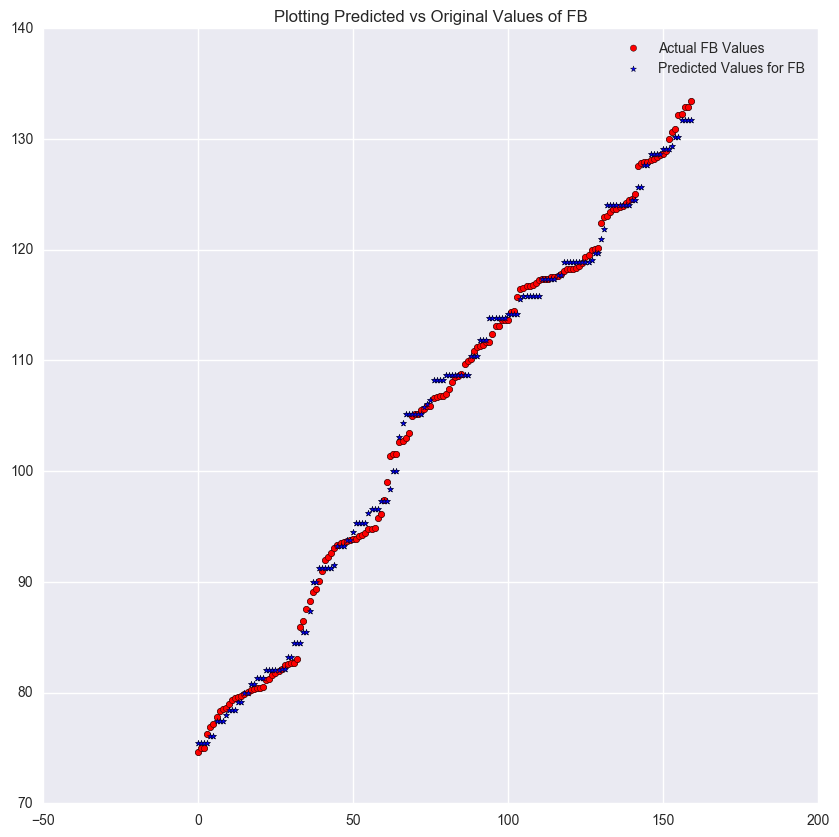

In [142]:
regression_type("Avrg_FB", comps_most_correlated("Avrg_FB"), "decision tree", parameters, ridge_alphas)

In [37]:
def comps_corr_2(comp):
    corr_comps = corr.sort_values(by=['{}'.format(comp)], ascending=False).T
    threshold_comps = [str(a) for a in corr_comps.head(0) if a != '{}'.format(comp)]
    return pd.DataFrame(corr_comps, columns=[threshold_comps])
    

Limiting the Companies based purely on their outputted coefficients in OLS
-----
When the regression was run with all the S&P 500 companies as x-values, I then selected only the companies that had coefficients that were over an absolute value of 2. I then inputted these companies into the regression and re-did the cut off criteria, and continued until the number of companies didn't change. You can see from the table below that it 3 updates for the number of companies to stay the same when using Facebook as the focus. Naturally, this process would mean that I would lose some variables, and so this would lead to some bias. However, I wanted to narrow down the field of S&P companies to look at. 

In [136]:
def limiting_xvalues(comp, data):
    revised_companies = data.keys()
    
    x_df = pd.DataFrame()
    for l in revised_companies:
        x_df = pd.concat([x_df, avrg[l]], axis=1)
    
    lr = LinearRegression()

    y = avrg[comp].values
    # x = comps_most_correlated('Avrg_FB').values
    x = x_df.values

    ss = StandardScaler()
    Xn = ss.fit_transform(x)
    
    xtrain, xtest, ytrain, ytest = train_test_split(Xn, y, test_size=0.3, random_state=10)

    lr.fit(X=xtrain, y=ytrain)
    ytrain_pred, ytest_pred = lr.predict(xtrain), lr.predict(xtest)

# Combining companies and their coefficients    
    
    header = [d for d in x_df.head(0)]
    
    explan_comps = {}
    for k in range(len(header)):
        if math.fabs(lr.coef_[k]) > 2:
            explan_comps[header[k]] = lr.coef_[k]
        else:
            pass
        
    return explan_comps

In [39]:
def initial_data_for_update(comp):
    initialized_data= {}
    for u in range(len([p for p in comps_corr_2(comp).head(0)])-1):
        initialized_data[[p for p in comps_corr_2(comp).head(0)][u]] = 10
    return initialized_data

In [40]:
data = initial_data_for_update("Avrg_FB")

In [41]:
update = limiting_xvalues("Avrg_FB", data)

In [42]:
iteration_1_keys = update.keys()

In [43]:
updated_var = pd.DataFrame(update.values(), columns=['Update 0'], index=iteration_1_keys)

In [44]:
for iterate in range(1, 4):
    update = limiting_xvalues("Avrg_FB", update)
    ud = pd.DataFrame(update.values(), columns=['Update {}'.format(iterate)], index=update.keys())
    updated_var = pd.concat([updated_var, ud], axis=1)

In [45]:
updated_var

Update 0  Update 1  Update 2  Update 3
Avrg_ALB   3.227232       NaN       NaN       NaN
Avrg_AMAT  2.120938       NaN       NaN       NaN
Avrg_AMZN  2.311787  6.448991  7.239520  8.768532
Avrg_AON   2.151165       NaN       NaN       NaN
Avrg_AVGO -2.239764  3.757054  5.580399  7.108164
Avrg_BEN  -2.148665  5.496606  4.791697  4.265441
Avrg_BIIB  2.119678       NaN       NaN       NaN
Avrg_C     2.490473 -2.034250       NaN       NaN
Avrg_ED    2.332137       NaN       NaN       NaN
Avrg_EMR   2.481788       NaN       NaN       NaN
Avrg_EQIX  2.581037  3.423563       NaN       NaN
Avrg_FCX  -2.043567 -2.072304 -2.893625 -2.344383
Avrg_FMC  -2.423054 -4.565515 -3.210105 -2.881490
Avrg_LLTC  2.204120       NaN       NaN       NaN
Avrg_MKC   3.645568       NaN       NaN       NaN
Avrg_NOC  -2.526068       NaN       NaN       NaN
Avrg_PFG  -2.259438  2.935767  3.606563  2.705081
Avrg_PLD  -2.062424       NaN       NaN       NaN
Avrg_PM   -2.068758  3.483146       NaN       NaN
Avrg_RF    2.140080  2.847771       NaN       NaN
Avrg_RHI  -2.936350 -3.238513 -3.881476 -4.603960
Avrg_TDC   2.101339       NaN       NaN       NaN
Avrg_ULTA -2.426850 -4.268800 -3.707818 -4.186173
Avrg_UNH   2.438455       NaN       NaN       NaN
Avrg_WEC  -2.148644  4.868846  3.426289  5.086869
Avrg_WMB  -2.001641       NaN       NaN       NaN

Review of the Updated Coefficient Process
------
It took 3 updates for the companies to remain fixed between updates. It's interesting because there are some coefficients that actually switched from being negative after the first iteration, to being positive in that last iteration. This could well be due to autocorrelation error that will occur as I take variables out. Nonetheless, the list of companies that I end up with be a good starting point, for which to focus on when making early analysis of the stock market. 

In [89]:
def get_updated_values(update):
    update_no = {}
    for i in range(len(updated_var)):
        if len(str(updated_var[update][i])) > 4:
            update_no[str(updated_var['Update 3'].keys()[i])] = updated_var[update][i]
        else:
            pass
    return update_no      

In [116]:
update_1 = get_updated_values('Update 1')
update_2 = get_updated_values('Update 2')
update_3 = get_updated_values('Update 3')

In [117]:
update_1_df = random_collection_of_companies(update_1.keys())
update_2_df = random_collection_of_companies(update_2.keys())
update_3_df = random_collection_of_companies(update_3.keys())

Using OLS I got the following results:

The coefficients are:
AVGO:
	7.10816399362
FCX:
	-2.34438262608
PFG:
	2.705080713
BEN:
	4.26544052186
ULTA:
	-4.18617327237
AMZN:
	8.76853151526
RHI:
	-4.60396000136
WEC:
	5.08686917609
FMC:
	-2.88149024895
The R squared score of the tested data is: 0.96
The score for the trained data is: 0.97
The MSE value in the tested data is: 12.77
The value for trained data is: 9.61


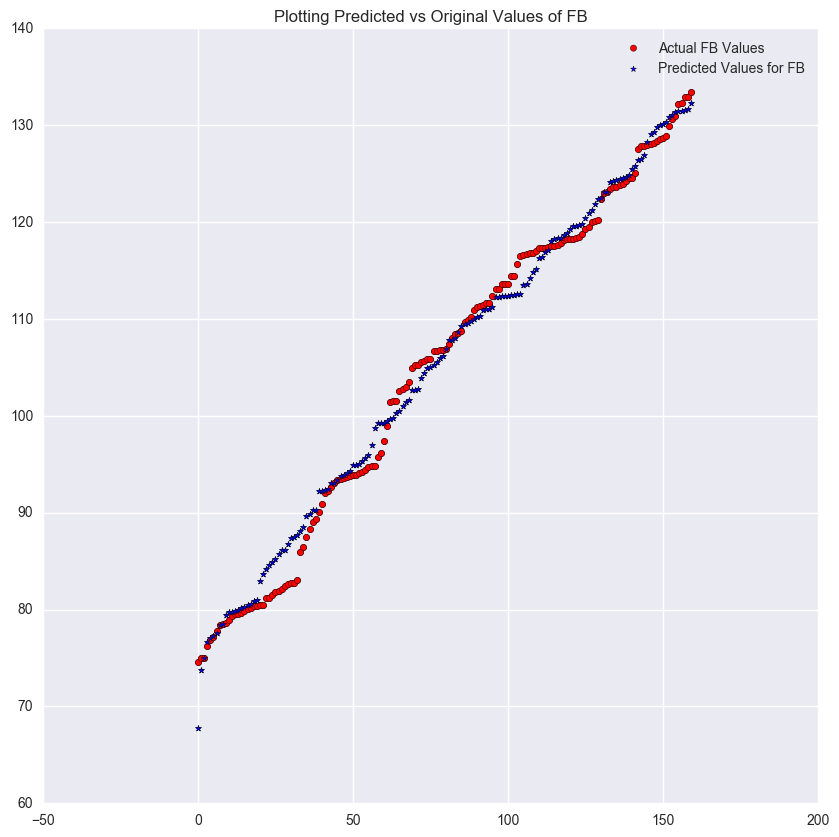

In [137]:
regression_type("Avrg_FB", update_2_df, "OLS", parameters, ridge_alphas)

Using the Ridge model, I got the following results and statistics:

The coefficients are:
AVGO:
	6.89249332844
FCX:
	-2.32578913377
PFG:
	2.62519282313
BEN:
	3.77985957027
ULTA:
	-3.56757629354
AMZN:
	8.30962103794
RHI:
	-4.44276187497
WEC:
	4.85946663811
FMC:
	-2.69570929718
The R squared score of the tested data is: 0.96
The score for the trained data is: 0.97
The MSE value in the tested data is: 12.83
The value for trained data is: 9.64


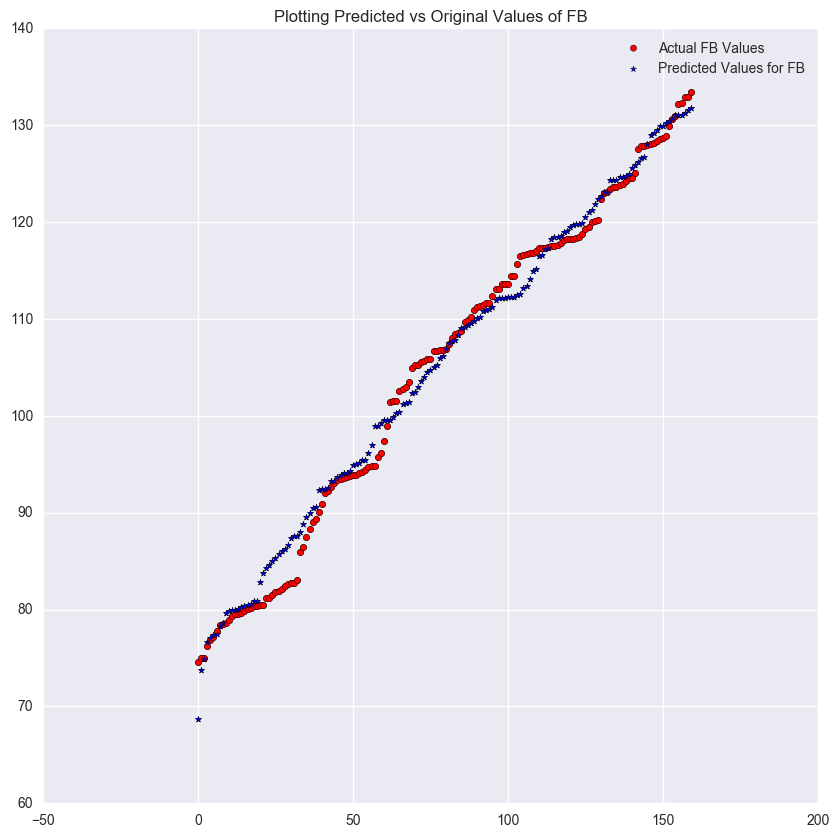

In [140]:
regression_type("Avrg_FB", update_2_df, "Ridge", parameters, ridge_alphas)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    1.9s finished


Using Decision Tree analysis I got the following results and statistics:

     feature  importance
0  Avrg_AVGO    0.021031
1   Avrg_FCX    0.089297
2   Avrg_PFG    0.000513
3   Avrg_BEN    0.001876
4  Avrg_ULTA    0.002131
5  Avrg_AMZN    0.042043
6   Avrg_RHI    0.720882
7   Avrg_WEC    0.008693
8   Avrg_FMC    0.113535
The R squared score of the tested data is: 0.98
The score for the trained data is: 1.00
The MSE value in the tested data is: 5.81
The value for trained data is: 0.30


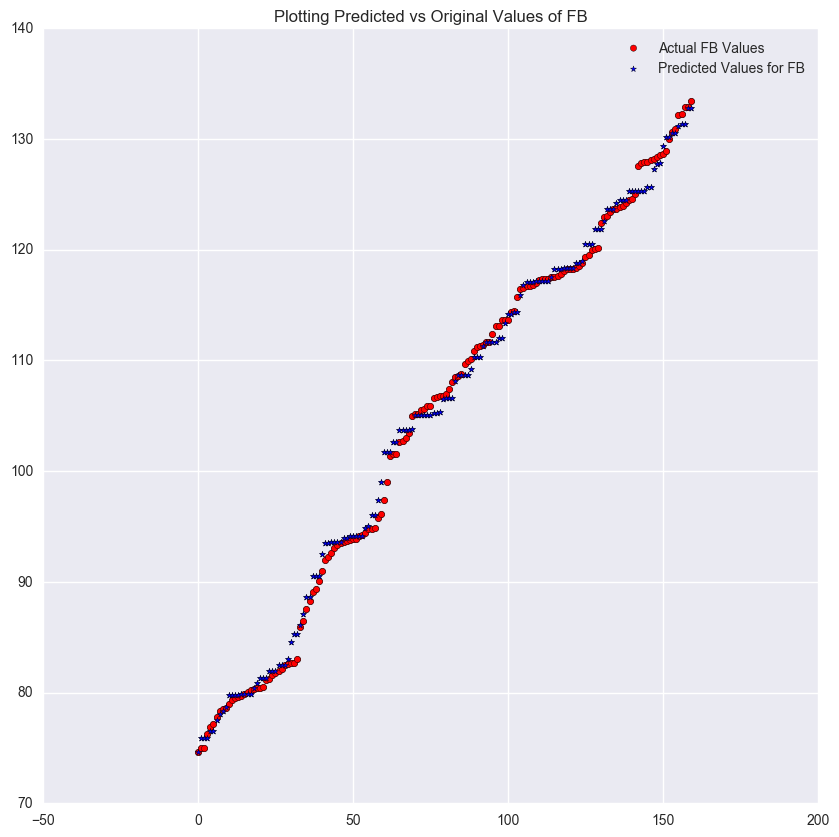

In [145]:
regression_type("Avrg_FB", update_2_df, "decision tree", parameters, ridge_alphas)

Conclusion
--------
On reflection I think the stock market is a very hard topic to tackle, especially with limited access to data. This process also got me thinking about the structure of stock data. Looking at the scatter plots, and the time series plots of a selection of companies, it made me realise how similar all the plots look on different timescales. They're almost fractal, so maybe tackling this problem from a fractal-mathematics point of view might lead to more conclusive and strong results. 
The R_2 and MSE score imply that decision trees produced the better results. There could be a degree of overfitting that I'm missing here, but I can only go off of what the results tell me, so I'd probably choose decision trees as my model of choice. It showed a R_2 score of (essentially) 1, which is obviously outstandingly good ... perhaps even too good. The MSE reflected this "too good" vibe, and was extremely low. So either my model was ridiculously good, or there something fishy going on. Honestly, I feel like it is a bit of both, I do think my model is good but only because many of the x-stocks are correlated to the y-stock, as well as being correlated to each other. I don't think it's realistic to assume that each of these stocks are independent of each other. Accepting the presence of this assumption means that a lot of the analysis has to be looked at quite suspiciously. 
However, it was a good exercise to explore stock market data. I think I'll have a closer look at fractal mathematics and see if there could be any leads in that direction. 